In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [73]:
# load feature vectors of songs from Spotify that last 30 seconds
with open("feature_spotify.pkl", "rb") as file:
    track_ids = pickle.load(file)
    features = pickle.load(file)

In [74]:
# dimensions
print("Samples", len(track_ids))
print("Features", len(features))
print("Local descriptors", len(features[0]))
print("Dimension of local descriptor", len(features[0][0]))



Samples 11903
Features 11903
Local descriptors 20
Dimension of local descriptor 1280


In [75]:
# verify if all the feature vectors have the same dimensions
for i, feature in enumerate(features):
    if feature.shape != (20, 1280):
        print(f"Dimension of song {track_ids[i]} is {feature.shape} ")

Dimension of song 6L9E5ONm7Mv8lraV53UR3X is (20, 920) 
Dimension of song 5kHiHWLcbsvTDtmHxBiaID is (20, 683) 
Dimension of song 01Bw3xiZ5PQfn0btMWICaQ is (20, 689) 
Dimension of song 6Ik9aiuaoEYxsEKGdQaEJB is (20, 1111) 
Dimension of song 7IKIOZ5xbzdFGQ2y7Tu0Wq is (20, 690) 
Dimension of song 6Na3LJmy6qmjK1SYzUhmZ6 is (20, 1278) 
Dimension of song 1wjzFQodRWrPcQ0AnYnvQ9 is (20, 897) 
Dimension of song 2tUBqZG2AbRi7Q0BIrVrEj is (20, 696) 
Dimension of song 3N4tKKBTxNI8OQIZbpS3u6 is (20, 799) 
Dimension of song 5AiNxLZufMUfR6ADAxxqOe is (20, 985) 
Dimension of song 7ssEhls1ZYEGtBsoovkMSe is (20, 1081) 
Dimension of song 5fqt5nfPEgbOuIajbZmkBv is (20, 1052) 
Dimension of song 6fYRgMy5JyRtCCupQK5j0E is (20, 657) 
Dimension of song 4HCsKNye8SYImpwXnurwmN is (20, 919) 
Dimension of song 23YEpFgAVvr0w3cDm7EQ1Q is (20, 920) 
Dimension of song 5kZRoc6Gz7u5eu4a0YM2LS is (20, 678) 
Dimension of song 1AlcpxsgzYwAJ1SfMPPWU4 is (20, 1034) 
Dimension of song 3kxfsdsCpFgN412fpnW85Y is (20, 1034) 
Dime

In [76]:
# delete the feature vectors that have different dimensions
preserved_indexes = [i for i, feature in enumerate(features)  if feature.shape == (20, 1280) ]
features = [features[i] for i in preserved_indexes]
track_ids = [track_ids[i] for i in preserved_indexes]
print(len(features))
print(len(track_ids))

11883
11883


# 1. Apply one PCA to all data

In [51]:
# collect all feature vectors of each song in a list
big_features = []
for feature in features:
    for ls in feature:
        big_features.append(ls)

big_features = np.array(big_features)


In [65]:
# normalize
big_features = (big_features - np.min(big_features, axis=0)) / (np.max(big_features, axis=0) - np.min(big_features, axis=0))

In [68]:
print(big_features.shape)

(237660, 1280)


In [69]:
""" 
Apply PCA to all of the feature vectors, the n_components by default is min(n_samples, n_features) - 1 (20)
"""

pca = PCA()
pca.fit(big_features)
# Accumulated sum that explain the variance by the number of components
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
# Compute the number of components that explain 90% of the variance
n_components_above_90 = np.argmax(explained_variance_ratio >= 0.9) + 1
print(n_components_above_90)



154


In [70]:
# Apply the number of components that explain 90% of the variance 
pca = PCA(n_components=n_components_above_90)
features_pca = pca.fit_transform(big_features)
print(features_pca.shape)


(237660, 154)


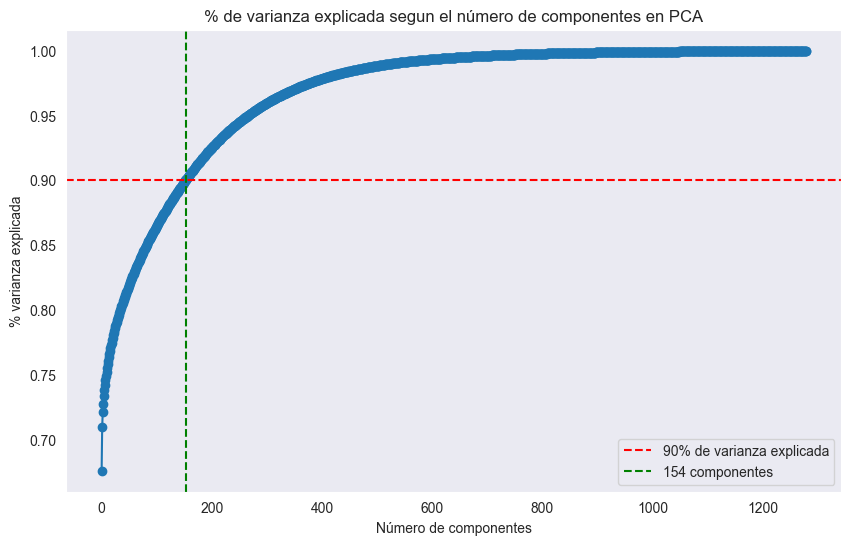

In [71]:
#Grafico
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio, marker="o")
plt.axhline(y=0.9, color="r", linestyle="--", label="90% de varianza explicada")
plt.axvline(x=n_components_above_90 - 1, color="g", linestyle="--", label=f"{n_components_above_90} componentes")
plt.title("% de varianza explicada segun el número de componentes en PCA")
plt.xlabel("Número de componentes")
plt.ylabel("% varianza explicada")
plt.legend()
plt.grid()
plt.show()


In [72]:
# save the pca features
""" 
IMPORTANT: the order of the track_ids is the same as the order of the features. The features_pca has 20 times the
number of track_ids, it happens bc the feature vectors of each song have 20 local descriptors, so i just
appended all the local descriptors of each song in a list.
To recover the feature vectors of a song, you only have to take 20 elements of the features_pca according to the index
"""
with open("pca_features.pkl", "wb") as file:
    pickle.dump(track_ids, file)
    pickle.dump(features_pca, file)

In [ ]:
# load the pkl
with open("pca_features.pkl", "rb") as file:
    track_ids = pickle.load(file)
    features_pca = pickle.load(file)

# 2. Apply PCA to each descriptor

In [77]:
# Apply PCA to each local descriptor of each song, collect the features in 20 lists
features_local = []
# divide the feature vectors of each song in 20 lists, each for a local descriptor
for i in range(20):
    features_temp = []
    for feature in features:
        features_temp.append(feature[i])
    features_local.append(features_temp)
features_local = np.array(features_local)
    
    
        

In [78]:
# normalize
for i in range(len(features_local)):
    features_local[i] = (features_local[i] - np.min(features_local[i], axis=0)) / (np.max(features_local[i], axis=0) - np.min(features_local[i], axis=0))

In [79]:
print(features_local.shape)

(20, 11883, 1280)


In [80]:
# Apply PCA to each of the 20 local descriptor by mfccs
features_local_pca = []
for feature_local in features_local:
    pca = PCA()
    pca.fit(feature_local)
    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    n_components_above_90 = np.argmax(explained_variance_ratio >= 0.9) + 1
    
    pca = PCA(n_components=n_components_above_90)
    features_pca_transform = pca.fit_transform(feature_local)
    features_local_pca.append(features_pca_transform)
    print("Dimension of local descriptor", features_pca_transform.shape)

Dimension of local descriptor (11883, 222)
Dimension of local descriptor (11883, 257)
Dimension of local descriptor (11883, 257)
Dimension of local descriptor (11883, 256)
Dimension of local descriptor (11883, 274)
Dimension of local descriptor (11883, 284)
Dimension of local descriptor (11883, 295)
Dimension of local descriptor (11883, 301)
Dimension of local descriptor (11883, 308)
Dimension of local descriptor (11883, 317)
Dimension of local descriptor (11883, 322)
Dimension of local descriptor (11883, 333)
Dimension of local descriptor (11883, 338)
Dimension of local descriptor (11883, 343)
Dimension of local descriptor (11883, 349)
Dimension of local descriptor (11883, 347)
Dimension of local descriptor (11883, 347)
Dimension of local descriptor (11883, 355)
Dimension of local descriptor (11883, 351)
Dimension of local descriptor (11883, 348)
